<p align="center">
<img src='../../img/VerticaMLPython.png' width="180px">
</p>

# Vertica ML Python Exercise 9

During this exercice, we will:
<ul>
    <li> Join Multiple Tables
    <li> Extract information from the new created dataset
</ul>
## Initialization

Let's create a cursor using the vertica_cursor function.

In [1]:
from vertica_ml_python.utilities import vertica_cursor
cur = vertica_cursor("VerticaDSN")

During this study, we will work with the flight delays dataset.

In [2]:
from vertica_ml_python import vDataframe
flights = vDataframe('flights', cur)

We can add data from other data source. We have information on the different airports and airlines.

In [3]:
from vertica_ml_python.utilities import drop_table
drop_table("airlines", cur)
drop_table("airports", cur)
from vertica_ml_python.utilities import read_csv
airlines = read_csv("flights/airlines.csv", cur)
airports = read_csv("flights/airports.csv", cur)

The table airlines was successfully dropped.
The table airports was successfully dropped.
The table public.airlines has been successfully created.
The table public.airports has been successfully created.


We can create the feature of exercise 8 (= 1 if the flight has a departure delay of more than 10 minutes, 0 otherwise)

In [4]:
flights.eval("is_dep_delay", "(CASE WHEN departure_delay > 10 THEN 1 ELSE 0 END)")

The new vColumn "is_dep_delay" was added to the vDataframe.


,destination_airport,scheduled_departure,departure_delay,arrival_delay,origin_airport,airline,is_dep_delay
0,ABE,2015-02-05 20:10:00,0,-18,DTW,EV,0
1,ABE,2015-02-05 20:34:00,-1,2,ATL,DL,0
2,ABE,2015-02-06 10:01:00,16,7,DTW,EV,1
3,ABE,2015-02-06 10:31:00,58,57,ATL,EV,1
4,ABE,2015-02-06 13:45:00,-6,3,ATL,EV,0
,...,...,...,...,...,...,...


<object>  Name: flights, Number of rows: 4068736, Number of columns: 7

## Joins

Let's explore the different data sources by displaying descriptive statistics of all the columns.

In [5]:
flights.describe(method = "categorical")

,dtype,unique,count,top,top_percent
"""destination_airport""",varchar(20),629,4068736,ATL,5.46
"""scheduled_departure""",timestamp,286101,4068736,2015-04-06 13:45:00,0.003
"""departure_delay""",int,1108,4068736,-3,7.178
"""arrival_delay""",int,1135,4068736,-8,2.926
"""origin_airport""",varchar(20),621,4068736,ATL,6.744
"""airline""",varchar(20),14,4068736,WN,21.818
"""is_dep_delay""",int,2,4068736,0,74.355


<object>

In [6]:
airlines.describe(method = "categorical")

,dtype,unique,count,top,top_percent
"""AIRLINE""",varchar(56),14,14,Alaska Airlines Inc.,7.143
"""IATA_CODE""",varchar(20),14,14,AA,7.143


<object>

In [7]:
airports.describe(method = "categorical")

,dtype,unique,count,top,top_percent
"""AIRPORT""",varchar(156),322,322,Aberdeen Regional Airport,0.311
"""CITY""",varchar(60),308,322,Jacksonville,0.621
"""COUNTRY""",varchar(20),1,322,USA,100.0
"""STATE""",varchar(20),54,322,TX,7.453
"""IATA_CODE""",varchar(20),322,322,ABE,0.311
"""LATITUDE""","numeric(10,6)",319,319,13.483450,0.313
"""LONGITUDE""","numeric(11,6)",319,319,-100.496310,0.313


<object>

<b>Question 1: </b>Compute the averaged number of delays per airline the entire year. Find which company is less subject to delays than the others. Explain why.

In [8]:
flights.groupby(["airline"], 
                ["AVG(is_dep_delay) AS avg_delay"]).join(
                                vdf = airlines, 
                                on = {"airline": "IATA_CODE"}, 
                                how = "inner", 
                                expr1 = ['avg_delay'], 
                                expr2 = ['AIRLINE']).sort(["avg_delay"]).head(100)

,avg_delay,AIRLINE
0,0.120894169026074,Hawaiian Airlines Inc.
1,0.151610455311973,Alaska Airlines Inc.
2,0.202019548609539,Delta Air Lines Inc.
3,0.208013099470416,US Airways Inc.
4,0.214619353950127,Skywest Airlines Inc.
5,0.224149229061426,Atlantic Southeast Airlines
6,0.237224198285354,American Airlines Inc.
7,0.249606101431736,Virgin America
8,0.254211911166964,American Eagle Airlines Inc.
9,0.293974651031235,Frontier Airlines Inc.


<object>  Name: flights, Number of rows: 14, Number of columns: 2

<p style="color:red">Hawaiian Airlines is less subject to delays than the other companies because when we go to vacation each minute is precious.</p>

<b>Question 2: </b>Compute the distance between all the airports.

In [9]:
distances = airports.join(vdf = airports, 
                          how = "cross", 
                          expr1 = ["IATA_CODE AS airport1", "LATITUDE AS airport1_latitude", "LONGITUDE AS airport1_longitude"],
                          expr2 = ["IATA_CODE AS airport2", "LATITUDE AS airport2_latitude", "LONGITUDE AS airport2_longitude"])
distances.filter("airport1 != airport2")
distances.eval("distance", "DISTANCE(airport1_latitude, airport1_longitude, airport2_latitude, airport2_longitude)")

322 elements were filtered
The new vColumn "distance" was added to the vDataframe.


,airport1,airport1_latitude,airport1_longitude,airport2,airport2_latitude,airport2_longitude,distance
0,ABE,40.652360,-75.440400,ABI,32.411320,-99.681900,2341.90022515853
1,ABE,40.652360,-75.440400,ABQ,35.040220,-106.609190,2791.44167745523
2,ABE,40.652360,-75.440400,ABR,45.449060,-98.421830,1934.49820074978
3,ABE,40.652360,-75.440400,ABY,31.535520,-84.194470,1281.62374218022
4,ABE,40.652360,-75.440400,ACK,41.253050,-70.060180,456.66493443057
,...,...,...,...,...,...,...


<object>  Name: airports, Number of rows: 103362, Number of columns: 7

<b>Question 3: </b>By computing the correlation between the distance and the arrival delays, look at the influence of the distance on the global delay.

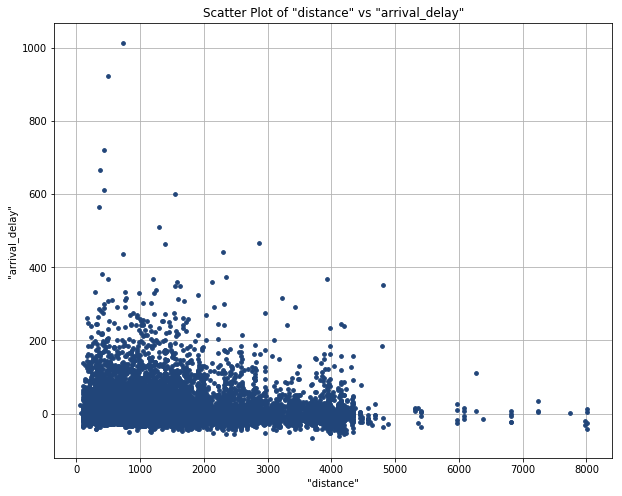

,arrival_delay,distance
0,-18,681.4468657252
1,2,1113.42055982721
2,7,681.4468657252
3,57,1113.42055982721
4,3,1113.42055982721
,...,...


<object>  Name: flights, Number of rows: 4068736, Number of columns: 2

In [10]:
%matplotlib inline
flights.join(vdf = distances,
             how = "left",
             on = {"destination_airport": "airport1", "origin_airport": "airport2"},
             expr1 = ["arrival_delay"],
             expr2 = ["distance"]).scatter(["distance", "arrival_delay"])

In [11]:
flights.join(vdf = distances,
             how = "left",
             on = {"destination_airport": "airport1", "origin_airport": "airport2"},
             expr1 = ["arrival_delay"],
             expr2 = ["distance"]).corr(method = "spearman")

-0.0669619299494039

<p style="color:red">There is a really small influence of the distance on the delay (we can see it in the scatter plot). Long-distance flights are less subject to delays than the others because of the range the pilot has to speed the plane.</p>